## Data preparation and sanitization

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

from core.utils.preprocessing import df_to_xydf, df_to_xy

# Read and sanitize the data
df = pd.read_csv("../data/t00/data_t00.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [15]:
df_full[["offer", "offer_final", "min_offer"]].describe()

,offer,offer_final,min_offer
count,103.000000,103.000000,103.000000
mean,43.592233,43.592233,40.679612
std,14.974119,14.974119,18.445050
min,0.000000,0.000000,0.000000
25%,40.000000,40.000000,35.000000
50%,50.000000,50.000000,45.000000
75%,50.000000,50.000000,50.000000
max,100.000000,100.000000,100.000000


In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_beta,103.0,1.022756,0.414026,0.384298,0.744767,0.786247,1.213732,1.937991
cc_criterion,103.0,0.365049,0.602321,-0.820956,-0.116322,0.121881,1.058885,1.266672
cc_false_alarm_avg_click_delay,103.0,111.265372,163.117615,0.000000,0.000000,0.000000,223.500000,851.000000
cc_false_alarm_rate,103.0,0.138350,0.197187,0.000000,0.000000,0.000000,0.250000,0.750000
cc_false_alarms,103.0,0.553398,0.788746,0.000000,0.000000,0.000000,1.000000,3.000000
cc_hit_avg_click_delay,103.0,246.536731,149.985094,0.000000,181.700000,287.500000,362.208333,489.000000
cc_hit_rate,103.0,0.545307,0.364696,0.000000,0.166667,0.666667,0.833333,1.000000
cc_hits,103.0,3.271845,2.188178,0.000000,1.000000,4.000000,5.000000,6.000000
cc_sensitivity,103.0,0.982211,1.008098,-0.967422,-0.232645,1.105217,1.641911,2.533344
cpc_expected_value,103.0,9.733511,1.265529,6.990600,8.798200,10.120800,10.671500,11.512800


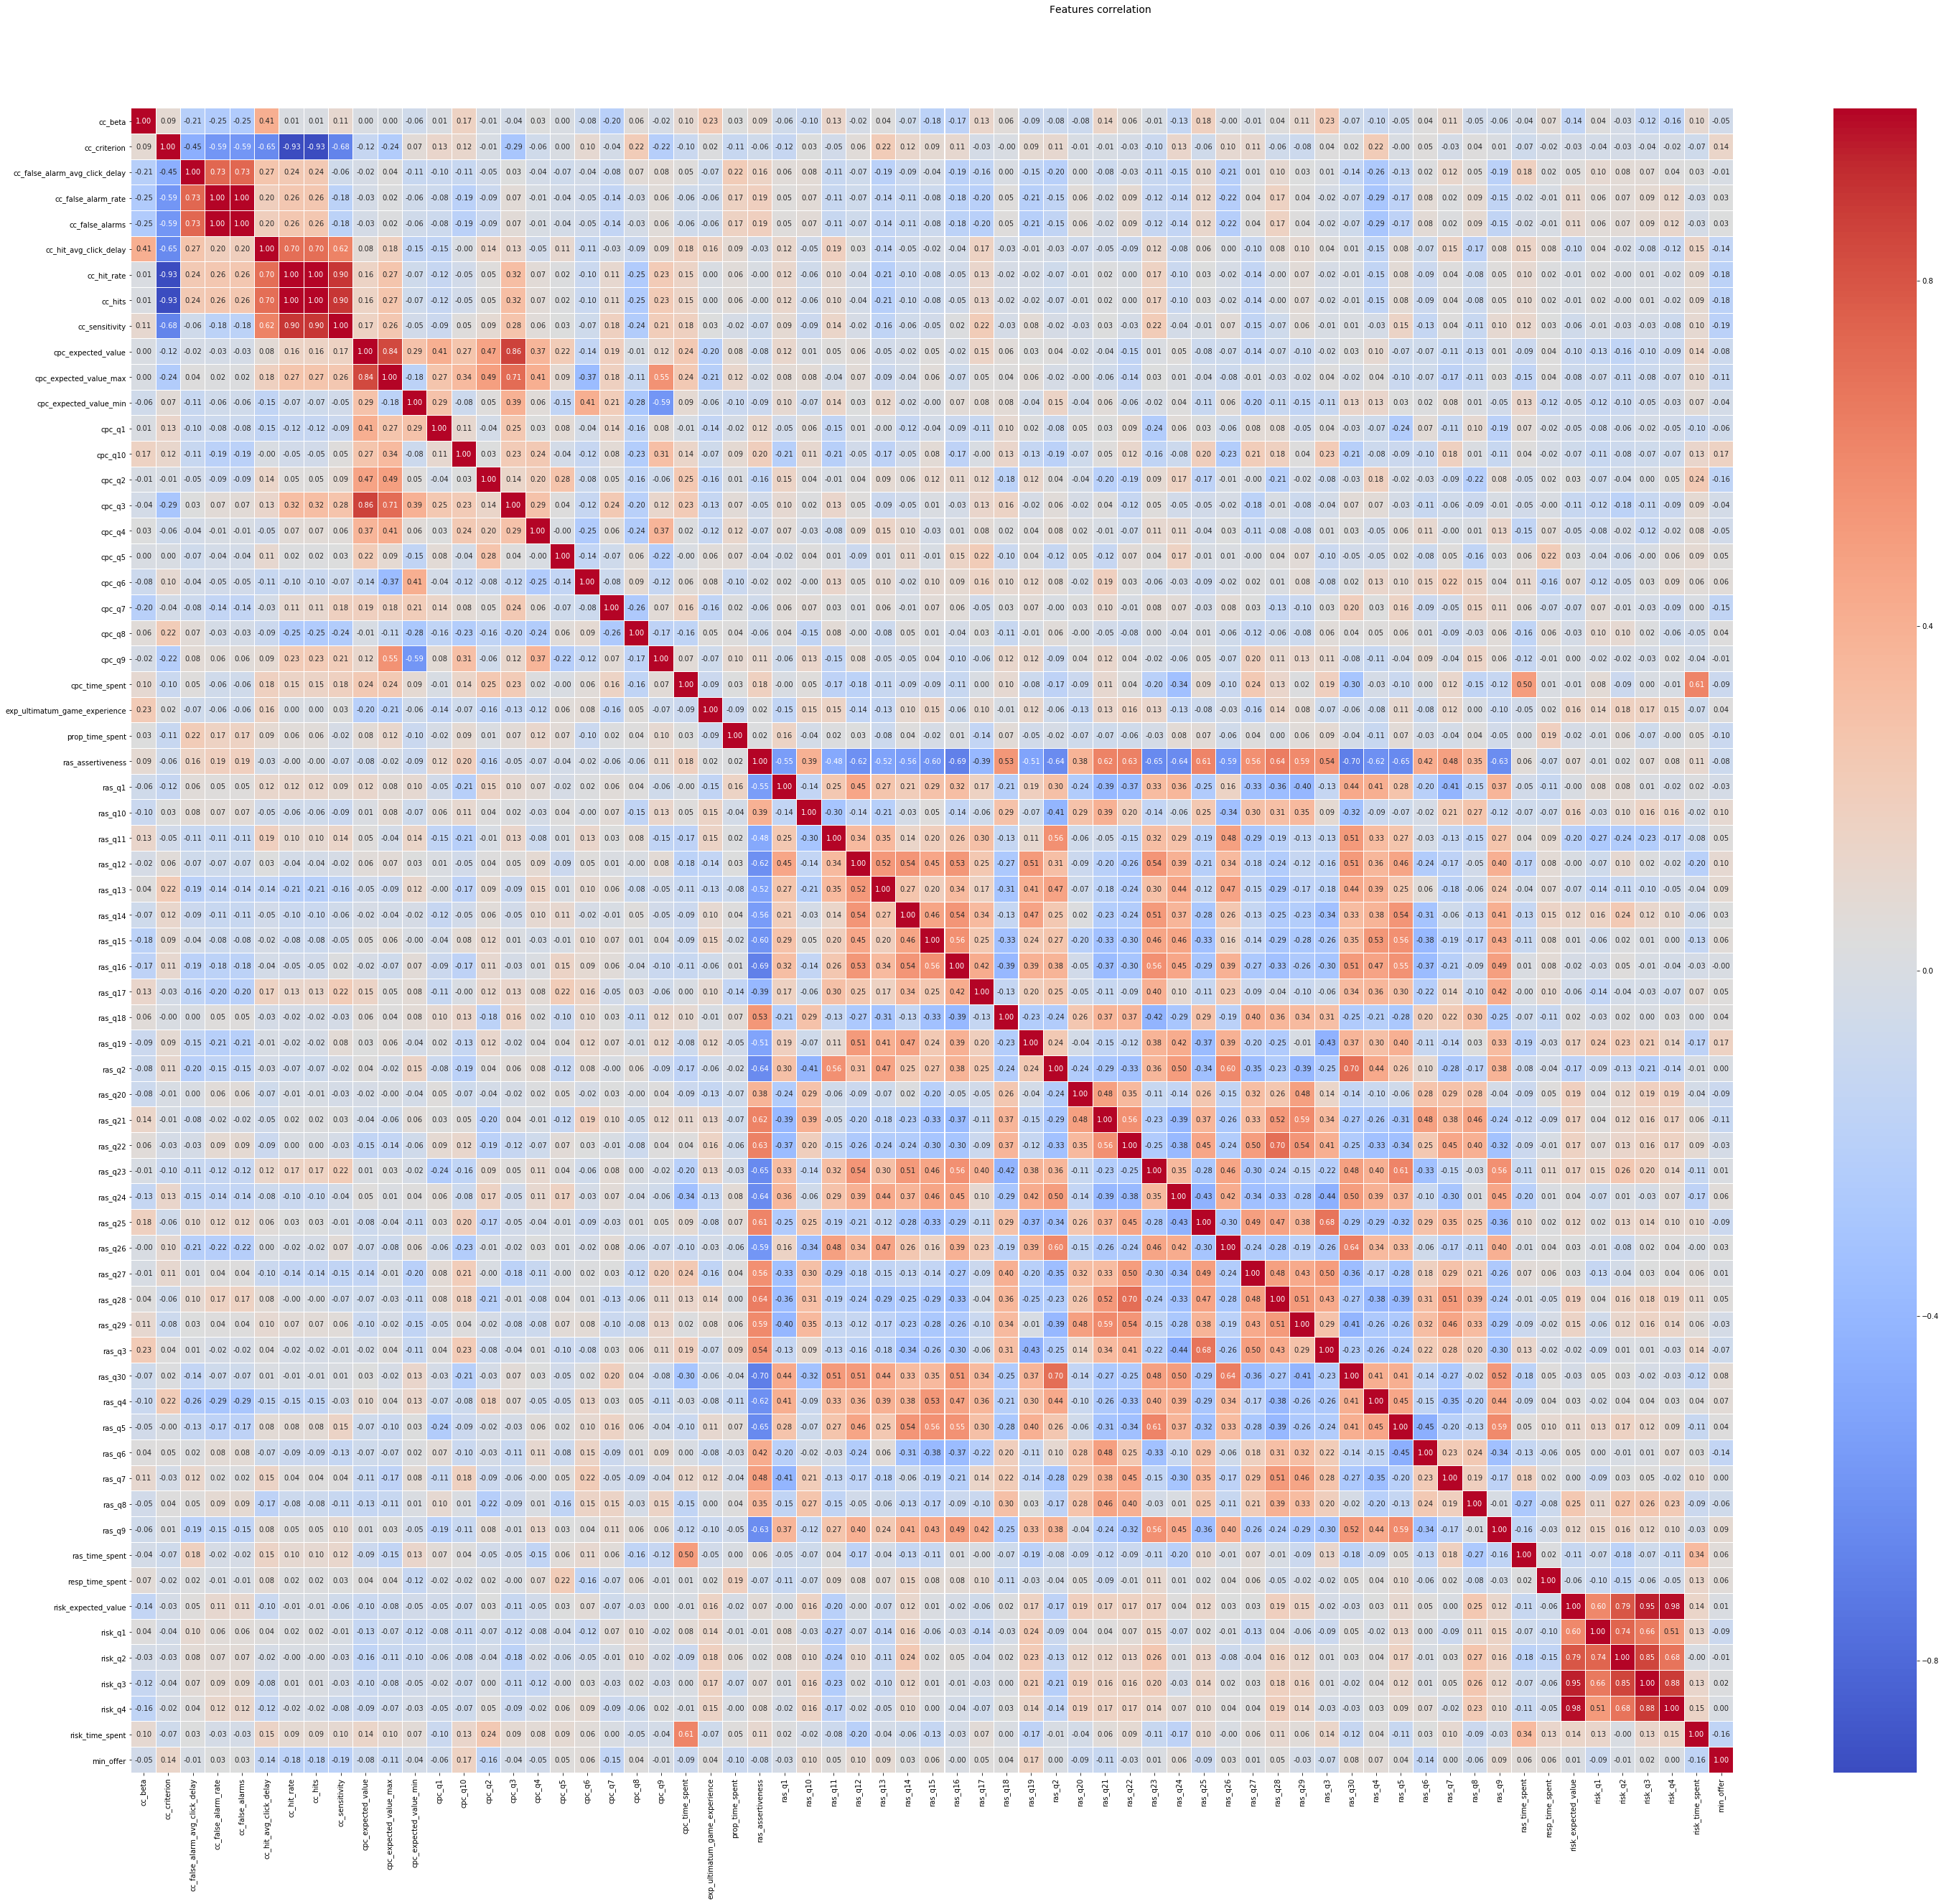

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(50, 40))
df_x, df_y = df_to_xydf(df)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']
corr = df_corr.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Features correlation', fontsize=14)

**Pair plots**

In [4]:
# #cols = ['density', 'residual sugar', 'total sulfur dioxide', 'fixed acidity']
# pp = sns.pairplot(df_corr, height=1.8, aspect=1.8,
#                   plot_kws=dict(edgecolor="k", linewidth=0.5),
#                   diag_kind="kde", diag_kws=dict(shade=True))

# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle('Attributes Pairwise Plots', fontsize=14)

**Target distribution**

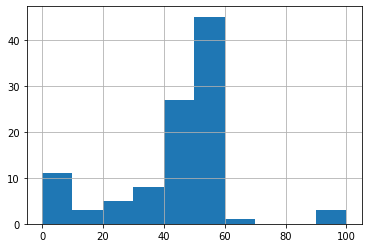

In [5]:
df_full['min_offer'].hist()

**Proposer offer distribution**

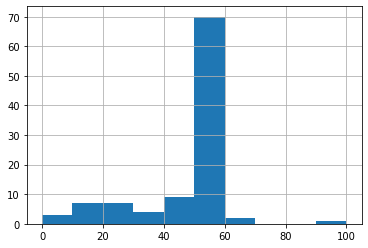

In [6]:
df_full['offer_final'].hist()

**Human (matched) average performance t00**

In [10]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain, gain_mean, rejection_ratio

print("human avg_gain_ratio", avg_gain_ratio(df_full['min_offer'], df_full['offer_final']))
print("human mean gain", gain_mean(df_full['min_offer'], df_full['offer_final']))
print("human rejection ratio", rejection_ratio(df_full['min_offer'], df_full['offer_final']))

human avg_gain_ratio 0.6822967300416278
human mean gain 41.116504854368934
human rejection ratio 0.2038834951456311


**Human average performance t00**

In [14]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain, gain_mean, rejection_ratio

print("human avg_gain_ratio", cross_compute(df_full['min_offer'], df_full['offer_final'], avg_gain_ratio))
print("human mean gain", cross_compute(df_full['min_offer'], df_full['offer_final'], gain_mean))
print("human rejection ration", cross_compute(df_full['min_offer'], df_full['offer_final'], rejection_ratio))

human avg_gain_ratio 0.6252058693740502
human mean gain 37.82118955603734
human rejection ration 0.2516731077387126


In [12]:
from core.models.metrics import cross_compute, avg_gain_ratio, gain, gain_mean, rejection_ratio

print("human avg_gain_ratio", cross_compute(df_full['min_offer'], np.array([50]), avg_gain_ratio))
print("human mean gain", cross_compute(df_full['min_offer'], np.array([50]), gain_mean))
print("human mean gain", cross_compute(df_full['min_offer'], np.array([50]), rejection_ratio))

human avg_gain_ratio 0.8130057615426879
human mean gain 47.57281553398058
human mean gain 0.04854368932038833


In [33]:
m = df.min()
mins = {k:v for k,v in m.items() if "time_spent" in k}
cols = list(mins)
df[(df["cpc_time_spent"]>mins["cpc_time_spent"]) & (df["ras_time_spent"]>mins["ras_time_spent"]) & (df["resp_time_spent"]>mins["resp_time_spent"]) & (df["risk_time_spent"]>mins["risk_time_spent"])]

,cc_beta,cc_criterion,cc_false_alarm_avg_click_delay,cc_false_alarm_rate,cc_false_alarms,cc_hit_avg_click_delay,cc_hit_rate,cc_hits,cc_sensitivity,cpc_expected_value,...,ras_q8,ras_q9,ras_time_spent,resp_time_spent,risk_expected_value,risk_q1,risk_q2,risk_q3,risk_q4,risk_time_spent
0,0.786247,-0.146466,271.000000,0.25,1,290.000000,0.833333,5,1.641911,9.5323,...,-1,-1,115,11,3.0125,1.05,1.50,3.50,6.00,52
1,0.744767,1.266672,0.000000,0.00,0,0.000000,0.000000,0,-0.232645,9.5323,...,-2,-2,227,12,1.8200,1.04,1.20,2.00,3.04,62
2,1.766303,0.359811,0.000000,0.00,0,362.750000,0.666667,4,1.581077,10.6715,...,1,2,95,21,1.8200,1.04,1.20,2.00,3.04,39
3,0.626283,-0.483711,205.000000,0.50,2,232.000000,0.833333,5,0.967422,10.2117,...,2,2,153,8,4.6450,1.09,1.99,5.50,10.00,101
4,1.766303,0.790538,0.000000,0.00,0,420.000000,0.333333,2,0.719622,8.6673,...,-2,3,107,9,2.0350,1.02,1.60,1.53,3.99,18
5,0.744767,1.266672,0.000000,0.00,0,0.000000,0.000000,0,-0.232645,8.9341,...,-1,-1,151,21,3.0125,1.05,1.50,3.50,6.00,44
6,1.766303,0.359811,0.000000,0.00,0,374.250000,0.666667,4,1.581077,9.8479,...,1,2,228,26,1.9525,1.05,1.20,2.52,3.04,106
7,1.255418,0.337245,472.000000,0.25,1,232.000000,0.500000,3,0.674490,10.2617,...,1,2,94,16,4.2700,1.09,1.99,5.00,9.00,30
8,1.255418,-0.337245,117.333333,0.75,3,85.666667,0.500000,3,-0.674490,10.1455,...,-3,-2,56,13,3.2325,1.05,1.38,3.50,7.00,10
9,0.744767,-0.116322,0.000000,0.00,0,403.333333,1.000000,6,2.533344,11.2161,...,-3,3,109,9,2.2225,1.05,1.33,2.52,3.99,20


In [34]:
mins

{'cpc_time_spent': 6.0,
 'prop_time_spent': 4.0,
 'ras_time_spent': 14.0,
 'resp_time_spent': 3.0,
 'risk_time_spent': 6.0}